# The Twin Problem

Suppose a mathematician is said that she expects twins. More over she is told that the twins seem to be two boys. She asks herself: *What is the probability of them being identical?*

First she checks what are the distribution of fraternal and identical twins:

In [1]:
from itertools import product

In [2]:
twin_types = 'FI'
frat_dist = [0.7, 0.3, ]
dict(zip(twin_types, frat_dist))

{'F': 0.7, 'I': 0.3}

And the distribution of boys and girls among new borns in general:

In [3]:
gender_types = 'BG'
gender_dist = [0.49, 0.51,]
dict(zip(gender_types, gender_dist))

{'B': 0.49, 'G': 0.51}

The possible outcomes are:

In [4]:
outcomes = [i+j for i, j in product(gender_types, repeat=2)]
outcomes

['BB', 'BG', 'GB', 'GG']

Two fraternal twins can be any of {BB, BG, GB, GG}, while for identical twins the probabilities for BG and GB are 0. Thus, the probabiliy distribution is dependent on the two type of twins: {F, I}.

For fraternal twins the probability of each of the outcomes is:

In [5]:
frat_twin_dist = [pi*pj for pi, pj in product(gender_dist, repeat=2)]
frat_twin_dist

[0.24009999999999998, 0.2499, 0.2499, 0.2601]

For identical twins it becomes:

In [6]:
iden_twin_dist = [(i==j)*pi*pj for (i, pi), (j, pj) in product(enumerate(gender_dist), repeat=2)]
iden_twin_dist = [v/sum(iden_twin_dist) for v in iden_twin_dist]
iden_twin_dist

[0.4800079968012795, 0.0, 0.0, 0.5199920031987205]

## Exact inference with pgmpy

This information is enough to answer the question. For this simple example it easy to derive it by hand. However, we are going to use the package [pgmpy](http://pgmpy.org/) to calculate it for us. This will allow us to easily modify the example in the next section.

In [7]:
from pgmpy.models import BayesianModel
from pgmpy.inference import VariableElimination
from pgmpy.factors.discrete import TabularCPD

First define the dependence of the distribution of twins ('T') on the their type 'H': {F, I}

In [8]:
# Defining the network structure
model = BayesianModel([('H', 'T')])

Then set the probabilities:

In [9]:
# Defining the CPDs:
cpd_h = TabularCPD('H', 2, [frat_dist])

cpd_t = TabularCPD('T', 4, list(zip(frat_twin_dist, iden_twin_dist)), evidence=['H'], evidence_card=[2])

# Associating the CPDs with the network structure.
model.add_cpds(cpd_h, cpd_t)

model.get_cpds()

[<TabularCPD representing P(H:2) at 0x7f2cd0127c50>,
 <TabularCPD representing P(T:4 | H:2) at 0x7f2cd0127c88>]

Next lets get the distribution of twin type 'H' given the observation 'BB':

In [10]:
infer = VariableElimination(model)

q = infer.query(variables=['H'], evidence={'T': outcomes.index('BB')})
print(q['H'])
dict(zip(twin_types, q['H'].values))

+-----+----------+
| H   |   phi(H) |
+=====+==========+
| H_0 |   0.5386 |
+-----+----------+
| H_1 |   0.4614 |
+-----+----------+


{'F': 0.5385609253391577, 'I': 0.46143907466084233}

### Complicate the model

This seems like a plausible model for the question. However, let's say that the mathematician does not trust the sonar reading. Hence, we attach a probability for the other outcomes too when the reading is 'BB'. Lets dentote the reading of the sonar with lower case letters (b,g) and the actual gender of the baby as (B, G).

We need the the probability distribution P(t|T), t in {b, g}, T in {B, G}. This can answer the question what is the probability to have a boy given that a reading of boy.

In [11]:
p_sonar = [[0.95, 0.05],
           [0.02, 0.98]]

In [12]:
def P_sonar(t, T):
    t1,t2 = t.upper()
    T1,T2 = T
    return p_sonar[gender_types.index(T1)][gender_types.index(t1)]*p_sonar[gender_types.index(T2)][gender_types.index(t2)]

In [13]:
P_sonar('bb', 'BG')

0.019

In [14]:
cpd_obs_t = [[P_sonar(t, T) for T in outcomes] for t in outcomes]
cpd_obs_t

[[0.9025, 0.019, 0.019, 0.0004],
 [0.0475, 0.9309999999999999, 0.001, 0.0196],
 [0.0475, 0.001, 0.9309999999999999, 0.0196],
 [0.0025000000000000005, 0.049, 0.049, 0.9603999999999999]]

In [15]:
cpd_obs_t = TabularCPD('OBS_T', 4, cpd_obs_t, evidence=['T'], evidence_card=[4])

In [16]:
comlicated_model = BayesianModel([('H', 'T'), ('T', 'OBS_T')])

In [17]:

# Associating the CPDs with the network structure.
comlicated_model.add_cpds(cpd_h, cpd_t, cpd_obs_t)

comlicated_model.get_cpds()

[<TabularCPD representing P(H:2) at 0x7f2cd0127c50>,
 <TabularCPD representing P(T:4 | H:2) at 0x7f2cd0127c88>,
 <TabularCPD representing P(OBS_T:4 | T:4) at 0x7f2cd0127fd0>]

In [18]:
complicated_infer = VariableElimination(comlicated_model)

complicated_q = complicated_infer.query(variables=['H', 'T'], evidence={'OBS_T': outcomes.index('BB')})
print(complicated_q['H'])
dict(zip(twin_types, complicated_q['H'].values))

+-----+----------+
| H   |   phi(H) |
+=====+==========+
| H_0 |   0.5492 |
+-----+----------+
| H_1 |   0.4508 |
+-----+----------+


/home/amarazov/workspace/mccpy/venv/lib/python3.6/site-packages/pgmpy/factors/discrete/DiscreteFactor.py:586: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  phi.values = phi.values[slice_]
/home/amarazov/workspace/mccpy/venv/lib/python3.6/site-packages/pgmpy/factors/discrete/DiscreteFactor.py:598: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  phi1.values = phi1.values[slice_]


{'F': 0.5491956189393926, 'I': 0.45080438106060744}

As a by product we have the distribution P(T|t):

In [19]:
print(complicated_q['T'])

+-----+----------+
| T   |   phi(T) |
+=====+==========+
| T_0 |   0.9765 |
+-----+----------+
| T_1 |   0.0115 |
+-----+----------+
| T_2 |   0.0115 |
+-----+----------+
| T_3 |   0.0005 |
+-----+----------+


## Approximate inference

For discrete distributions we can calculate the desired probability distribution by enumerating the outcomes. For continous distribution this might not be possible. The integrals may be just too complex. For this reason we can use approximote inference. There are two main types:
- variational inference
- Monte Carlo sampling
Below we demontrate the first approach using [pyro](https://pyro.ai/)

In [20]:
import matplotlib.pyplot as plt
import numpy as np
from torch import tensor, eye

import pyro
import pyro.infer
import pyro.optim
from pyro.distributions import *
import torch.distributions.constraints as constraints
from itertools import product
pyro.set_rng_seed(101)

In [21]:
gender2ix = {k:tensor(i) for i, k in enumerate(gender_types)}

Let's define a model that generates twins according the above probabilities. First the type of twin is determined by calling `fraternety()`. If they are identical the gender of child2 has probability 100% for the gender of child 1.

In [22]:
def twins():
    birth_dist = Categorical(tensor(gender_dist))
    frat = fraternety()
    if frat == 'I':
        child1 = pyro.sample('child1', birth_dist)
        point_dist = Categorical(eye(2)[child1])
        child2 = pyro.sample('child2', point_dist)
    else:
        child1 = pyro.sample('child1', birth_dist)
        child2 = pyro.sample('child2', birth_dist)
    return frat + gender_types[child1] + gender_types[child2]

In [23]:
def fraternety():
    frat = pyro.sample('fraternety', Categorical(tensor(frat_dist)))
    return twin_types[frat]

In [24]:
[twins() for _ in range(10)]

['FGB', 'FBG', 'FBG', 'IBB', 'FGB', 'IBB', 'IGG', 'FBB', 'IBB', 'FGG']

A guide function is the type of function we seek the posterior distribution to be like. Here we know exactly how it should look but in other cases we can only hope it is general enough to approximate the posterior well. 

In [25]:
def twins_parametrized_guide():
    a = pyro.param('a', tensor([0.5, 0.5]), constraint=constraints.simplex)
    return pyro.sample('fraternety', Categorical(a))

In [26]:
given = 'BB'
conditioned_twins = pyro.condition(twins, data={'child1': gender2ix[given[0]], 'child2': gender2ix[given[1]]})

infered P(fraternal|BB) = [0.5288604497909546, 0.4711395800113678]
exact   P(fraternal|BB) = [0.53856093 0.46143907]


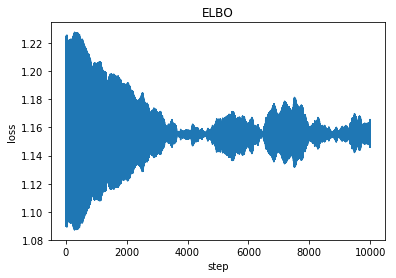

In [27]:
pyro.clear_param_store()
svi = pyro.infer.SVI(
    model=conditioned_twins,
    guide=twins_parametrized_guide,
    optim=pyro.optim.SGD({"lr": 0.0005, "momentum":0.1}),
    loss=pyro.infer.Trace_ELBO()
)


losses, pb, pg  = [], [], []
num_steps = 10000
for t in range(num_steps):
    losses.append(svi.step())
    pb.append(pyro.param("a")[0])
    pg.append(pyro.param("a")[1])

plt.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss");
print(f'infered P(fraternal|{given}) =', pyro.param("a").tolist())
print(f'exact   P(fraternal|{given}) =', q['H'].values)

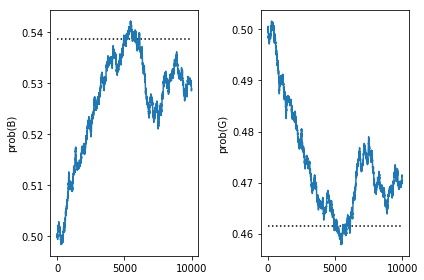

In [28]:
plt.subplot(1,2,1)
pb_exact = q['H'].values[0]
plt.plot([0,num_steps],[pb_exact, pb_exact], 'k:')
plt.plot(pb)
plt.ylabel('prob(B)')

plt.subplot(1,2,2)
plt.ylabel('prob(G)')
pg_exact = q['H'].values[1]
plt.plot([0,num_steps],[pg_exact, pg_exact], 'k:')
plt.plot(pg)
plt.tight_layout()